In [22]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost imblearn



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import pandas as pd

df = pd.read_csv("patient_priority.csv")

print("Shape:", df.shape)
print("\nColumns:")
print(df.columns)

print("\nNull counts:")
print(df.isnull().sum())

print("\nTriage value counts:")
print(df["triage"].value_counts())

Shape: (6962, 18)

Columns:
Index(['Unnamed: 0', 'age', 'gender', 'chest pain type', 'blood pressure',
       'cholesterol', 'max heart rate', 'exercise angina', 'plasma glucose',
       'skin_thickness', 'insulin', 'bmi', 'diabetes_pedigree', 'hypertension',
       'heart_disease', 'Residence_type', 'smoking_status', 'triage'],
      dtype='object')

Null counts:
Unnamed: 0             0
age                    0
gender                 1
chest pain type        0
blood pressure         0
cholesterol            0
max heart rate         0
exercise angina        0
plasma glucose         0
skin_thickness         0
insulin                0
bmi                    0
diabetes_pedigree      0
hypertension           0
heart_disease          0
Residence_type         0
smoking_status         0
triage               410
dtype: int64

Triage value counts:
triage
yellow    5637
green      440
orange     346
red        129
Name: count, dtype: int64


In [24]:
# Data cleaning 
import numpy as np

print("Original shape:", df.shape)

if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

df["triage"] = df["triage"].astype(str).str.strip().str.lower()

before = df.shape[0]#
df = df.dropna(subset=["triage"])
print("Dropped rows with missing triage:", before - df.shape[0])

df = df.rename(columns={
    "chest pain type": "chest_pain_type",
    "blood pressure": "blood_pressure",
    "max heart rate": "max_heart_rate",
    "exercise angina": "exercise_angina",
    "Residence_type": "residence_type",
    "plasma glucose": "plasma_glucose"
})

df["residence_type"] = df["residence_type"].astype(str).str.strip().str.lower()
df["residence_type"] = df["residence_type"].map({
    "urban": 1,
    "rural": 0
})

df["smoking_status"] = df["smoking_status"].astype(str).str.strip().str.lower()
df["smoking_status"] = df["smoking_status"].astype("category").cat.codes

df["chest_pain_type"] = df["chest_pain_type"].astype(str).str.strip().str.lower()
df["chest_pain_type"] = df["chest_pain_type"].astype("category").cat.codes

triage_to_ctas = {
    "red": 1,
    "orange": 2,
    "yellow": 3,
    "green": 4,
    "blue": 5,   
}
df["ctas_level"] = df["triage"].map(triage_to_ctas)

df = df.dropna(subset=["ctas_level"])
df["ctas_level"] = df["ctas_level"].astype(int)

for col in df.columns:
    if col != "triage":  
        df[col] = pd.to_numeric(df[col], errors="coerce")

numeric_cols = df.select_dtypes(include=["float64", "int64"]).columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())

print("Cleaned shape:", df.shape)
print("\nCTAS distribution:")
print(df["ctas_level"].value_counts().sort_index())

df.to_csv("patient_priority_clean.csv", index=False)
print("\nSaved cleaned data to patient_priority_clean.csv")


Original shape: (6962, 18)
Dropped rows with missing triage: 0
Cleaned shape: (6552, 18)

CTAS distribution:
ctas_level
1     129
2     346
3    5637
4     440
Name: count, dtype: int64

Saved cleaned data to patient_priority_clean.csv


Shape of the dataset: (6552, 18)

CTAS distribution:
ctas_level
1     129
2     346
3    5637
4     440
5       0
Name: count, dtype: int64


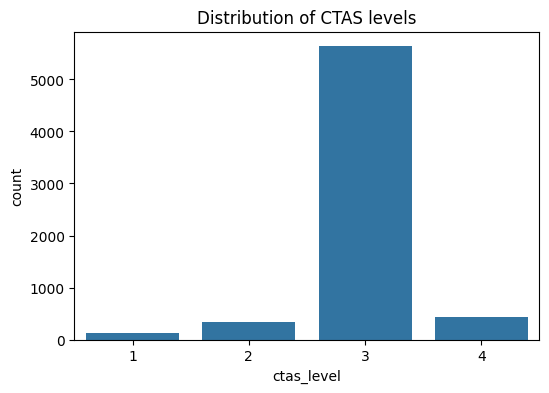


Statistical summary
               age       gender  chest_pain_type  blood_pressure  cholesterol  \
count  6552.000000  6552.000000      6552.000000     6552.000000  6552.000000   
mean     58.233822     0.533730         0.560592      110.490842   185.336386   
std      11.809133     0.498899         1.285283       21.634696    32.596675   
min      28.000000     0.000000         0.000000       60.000000   150.000000   
25%      49.000000     0.000000         0.000000       93.000000   164.000000   
50%      57.000000     1.000000         0.000000      113.000000   179.000000   
75%      66.000000     1.000000         0.000000      128.000000   193.000000   
max      82.000000     1.000000         4.000000      165.000000   294.000000   

       max_heart_rate  exercise_angina  plasma_glucose  skin_thickness  \
count     6552.000000      6552.000000     6552.000000     6552.000000   
mean       163.418956         0.065324       98.653449       57.045482   
std         15.451970      

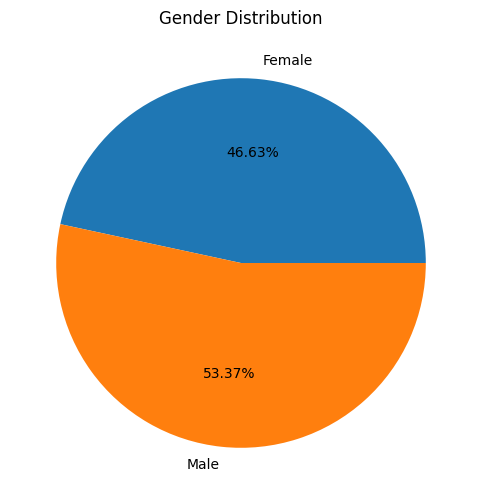

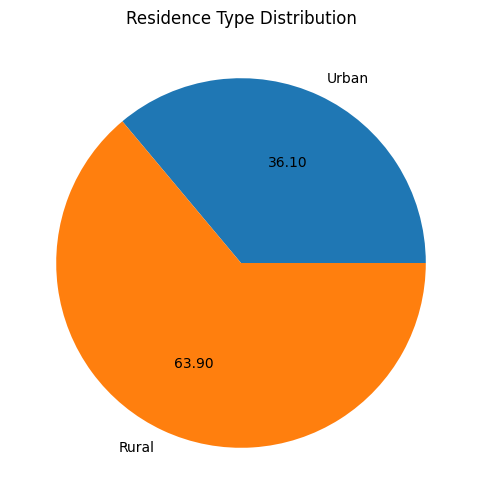

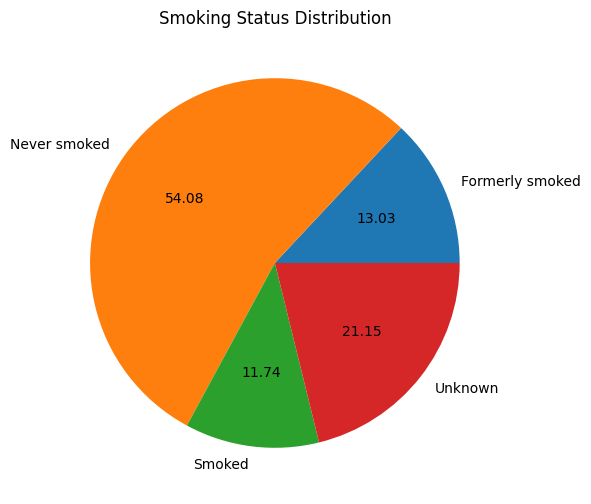

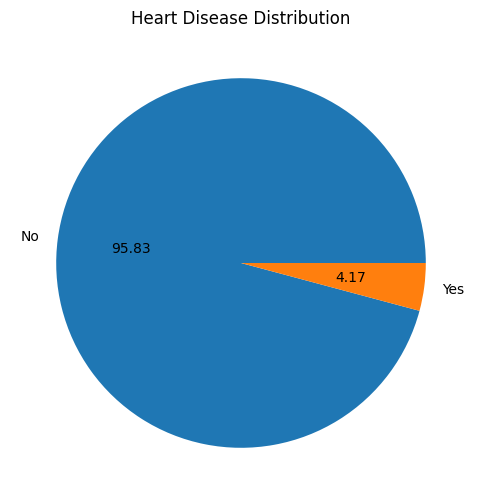

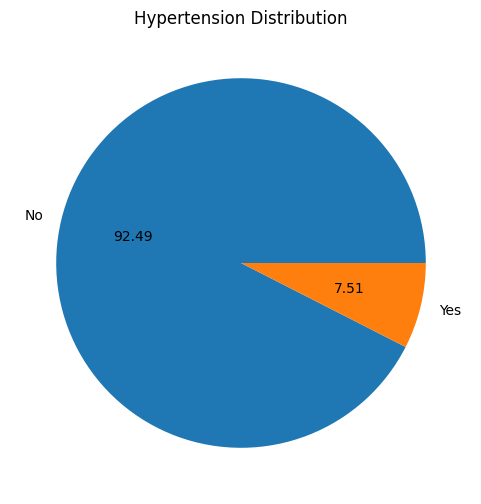

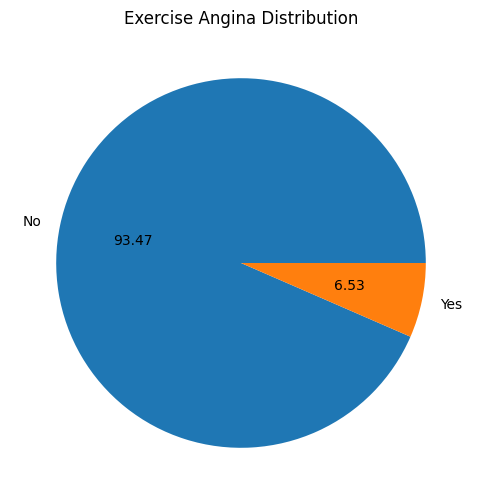

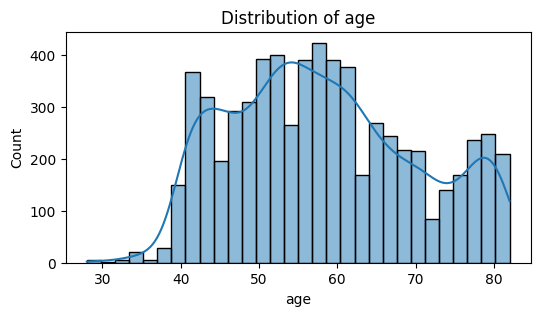

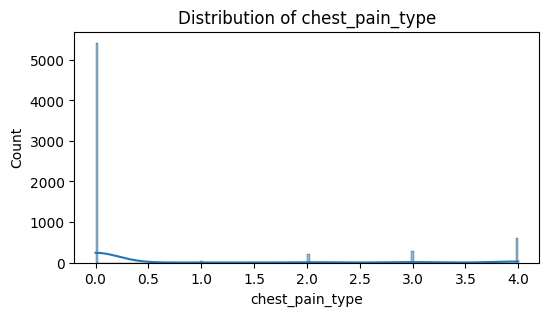

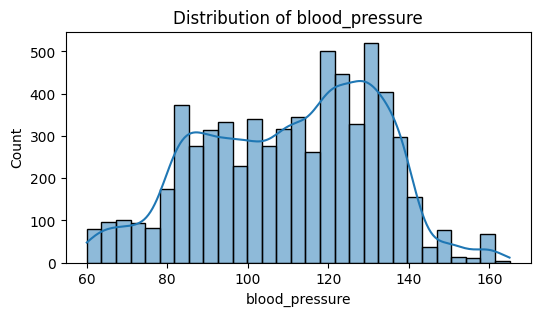

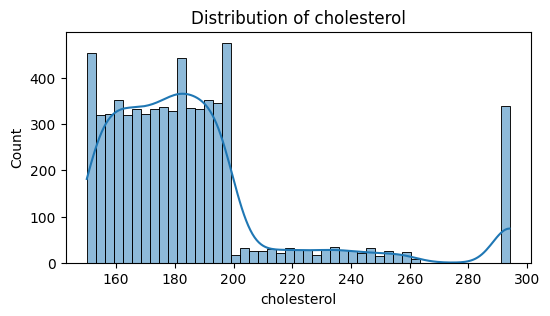

In [ ]:
# Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("patient_priority_clean.csv")
print("Shape of the dataset:", df.shape)

# --- CTAS distribution ---

all_levels = [1, 2, 3, 4, 5]
print("\nCTAS distribution:")
print(df["ctas_level"].value_counts().reindex(all_levels, fill_value=0))
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="ctas_level")
plt.title("Distribution of CTAS levels")
plt.show()

# --- Numeric columns analysis ---
pie_cols = ['gender', 'exercise_angina', 'residence_type', 'smoking_status', 'heart_disease', 'hypertension']

numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != "ctas_level"]

print("\nStatistical summary")
print(df[numeric_cols].describe())

gender_labels = ['Female', 'Male']
gender_counts = df['gender'].value_counts().sort_index() # 0 = Female, 1 = Male
plt.figure(figsize=(6,6))
plt.pie(gender_counts, labels=gender_labels, autopct="%0.2f%%")
plt.title("Gender Distribution")
plt.show()

residence_counts = df['residence_type'].value_counts().sort_index()
labels_residence = ['Urban', 'Rural']
plt.figure(figsize=(6,6))
plt.pie(residence_counts, labels=labels_residence, autopct="%0.2f")
plt.title("Residence Type Distribution")
plt.show()

smoking_counts = df['smoking_status'].value_counts().sort_index()
labels_smoking = ['Formerly smoked','Never smoked', 'Smoked', 'Unknown']
plt.figure(figsize=(6,6))
plt.pie(smoking_counts, labels=labels_smoking, autopct="%0.2f")
plt.title("Smoking Status Distribution")
plt.show()

for col in ['heart_disease', 'hypertension', 'exercise_angina']:
 counts = df[col].value_counts().sort_index()
 labels = ['No', 'Yes']
 plt.figure(figsize=(6,6))
 plt.pie(counts, labels=labels, autopct="%0.2f")
 plt.title(f"{col.replace('_',' ').title()} Distribution")
 plt.show()

hist_cols = [c for c in numeric_cols if c not in pie_cols]
for col in hist_cols:
 plt.figure(figsize=(6,3))
 sns.histplot(df[col], kde=True)
 plt.title(f"Distribution of {col}")
 plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


In [ ]:
# Data Augmentation for CTAS Level 5
df = pd.read_csv("patient_priority_clean.csv")

# Define realistic low-risk ranges for CTAS 5
level5_ranges = {
"age": (18, 50),
"blood_pressure": (90, 120),
"cholesterol": (150, 200),
"max_heart_rate": (60, 100),
"bmi": (18.5, 25),
"plasma_glucose": (70, 100),
"skin_thickness": (20, 40),
"insulin": (15, 100),
"diabetes_pedigree": (0, 0.5),
"heart_disease": (0, 0),  
"hypertension": (0, 0),    
"exercise_angina": (0, 0),     
"gender": (0, 1),              
"residence_type": (0, 1),     
"smoking_status": (0, 1),  
"chest_pain_type": (0, 1) 
}

int_cols = ["age", "blood_pressure", "cholesterol", "max_heart_rate", "skin_thickness", "insulin"]

n_new = 500
rng = np.random.default_rng(42)

synth = pd.DataFrame()
for col, (low, high) in level5_ranges.items():
 if col in ["gender", "residence_type", "smoking_status", "chest_pain_type"]:
  synth[col] = rng.integers(low, high+1, size=n_new)
 elif col in ["heart_disease", "hypertension", "exercise_angina"]:
  synth[col] = np.zeros(n_new, dtype=int)
 else:
  synth[col] = rng.uniform(low, high, size=n_new)
  if col in int_cols:
   synth[col] = synth[col].round(0).astype(int)
  elif col in ["plasma_glucose", "bmi"]:
   synth[col] = synth[col].round(1)
  elif col == "diabetes_pedigree":
   synth[col] = synth[col].round(5)

synth["ctas_level"] = 5
synth["triage"] = "blue"

df_final = pd.concat([df, synth], ignore_index=True)

print("\nFinal CTAS distribution:")
print(df_final["ctas_level"].value_counts().sort_index())

df_final.to_csv("patient_priority_final.csv", index=False)
print("\nSaved final dataset to patient_priority_final.csv")


Final CTAS distribution:
ctas_level
1     129
2     346
3    5637
4     440
5     500
Name: count, dtype: int64

Saved final dataset to patient_priority_final.csv


In [ ]:
df = pd.read_csv("patient_priority_final.csv")
df.head()

X = df.drop(columns=["ctas_level", "triage"])
y = df["ctas_level"] - 1

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

scaler = StandardScaler()
X_train_scaled= scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "SVC": SVC(kernel="rbf", probability=True),
    "KNN": KNeighborsClassifier(),
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(max_depth=10),
    "LogisticRegression": LogisticRegression(max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=2),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=2),
    "Bagging": BaggingClassifier(n_estimators=100, random_state=2),
    "ExtraTrees": ExtraTreesClassifier(n_estimators=100, random_state=2),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=100),
    "XGBoost": XGBClassifier(n_estimators=100, random_state=2)
}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score

def train_model(model, X_tr, y_tr, X_te, y_te):
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    prec = precision_score(y_te, y_pred, average="weighted", zero_division=1)
    return acc, prec

c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but GaussianNB was fitted without feature names
  warnings.warn(


SVC: Accuracy=0.7994, Precision=0.8397
KNN: Accuracy=0.8207, Precision=0.8520
NaiveBayes: Accuracy=0.7994, Precision=0.8397
DecisionTree: Accuracy=0.9965, Precision=0.9967
LogisticRegression: Accuracy=0.0624, Precision=0.9415


c:\Users\areej\AppData\Local\Programs\Python\Python314\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


RandomForest: Accuracy=0.9957, Precision=0.9958
AdaBoost: Accuracy=0.9872, Precision=0.9899
Bagging: Accuracy=0.9965, Precision=0.9967
ExtraTrees: Accuracy=0.9695, Precision=0.9701
GradientBoosting: Accuracy=1.0000, Precision=1.0000
XGBoost: Accuracy=0.9979, Precision=0.9979


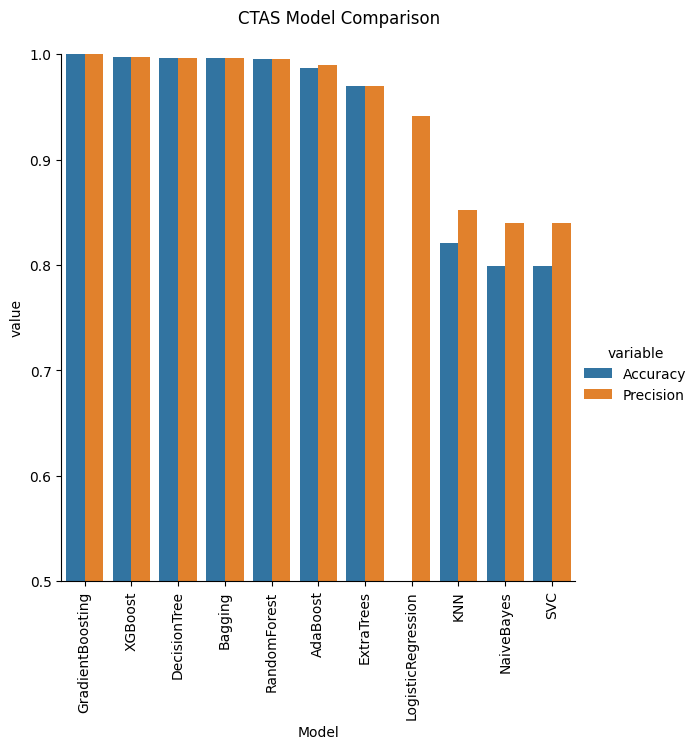

                 Model  Accuracy  Precision
9     GradientBoosting  1.000000   1.000000
10             XGBoost  0.997874   0.997922
3         DecisionTree  0.996456   0.996696
7              Bagging  0.996456   0.996696
5         RandomForest  0.995748   0.995778
6             AdaBoost  0.987243   0.989882
8           ExtraTrees  0.969525   0.970142
4   LogisticRegression  0.062367   0.941523
1                  KNN  0.820695   0.851962
2           NaiveBayes  0.799433   0.839660
0                  SVC  0.799433   0.839660


In [ ]:
accuracy_list, precision_list, names = [], [], []

for name, model in models.items():
    if name in ["SVC", "KNN", "LogisticRegression", "NaiveBayes"]:
        X_tr, X_te = X_train_scaled, X_test_scaled
    else:
        X_tr, X_te = X_train.values, X_test.values

    acc, prec = train_model(model, X_tr, y_train, X_te, y_test)
    print(f"{name}: Accuracy={acc:.4f}, Precision={prec:.4f}")
    names.append(name)
    accuracy_list.append(acc)
    precision_list.append(prec)

performance_df = pd.DataFrame({
    "Model": names,
    "Accuracy": accuracy_list,
    "Precision": precision_list
}).sort_values("Precision", ascending=False)

perf_melt = pd.melt(performance_df, id_vars="Model")

g = sns.catplot(
    x="Model",
    y="value",
    hue="variable",
    data=perf_melt,
    kind="bar",
    height=6
)

g.set_xticklabels(rotation=90) 
g.set(ylim=(0.5, 1.0)) 
g.fig.suptitle("CTAS Model Comparison", y=1.05) 
plt.show()

print(performance_df)